# Time Series Fundamentals

In [458]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
import matplotlib.pyplot as plt

In [10]:
#get data
data_path = 'BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv'
bitcoin_df = pd.read_csv(data_path, parse_dates=['Date'], index_col=['Date'])
print(f'length : {len(bitcoin_df)} row')
bitcoin_df.head(10)

length : 2787 row


,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566
2013-10-06,BTC,120.65533,121.33866,121.85216,120.55450
2013-10-07,BTC,121.79500,120.65533,121.99166,120.43199
2013-10-08,BTC,123.03300,121.79500,123.64016,121.35066
2013-10-09,BTC,124.04900,123.03300,124.78350,122.59266


In [19]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [28]:
#only want closing price
bitcoin_prices = pd.DataFrame({'Price':bitcoin_df['Closing Price (USD)']})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


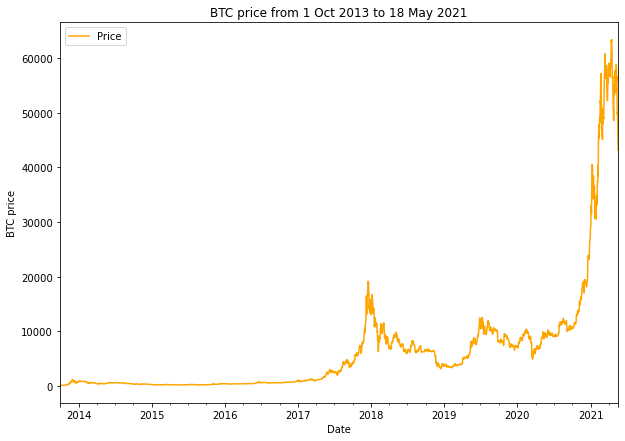

In [36]:
bitcoin_prices.plot(figsize=(10,7), color='orange')
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Create train and test set
time seris : use past feature to predict the future

In [73]:
times = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

train_size = int(len(times) *.8)
X_train, y_train = times[:train_size], prices[:train_size]
X_test, y_test = times[train_size:], prices[train_size:]

X_train.shape, X_test.shape , len(times)

((2229,), (558,), 2787)

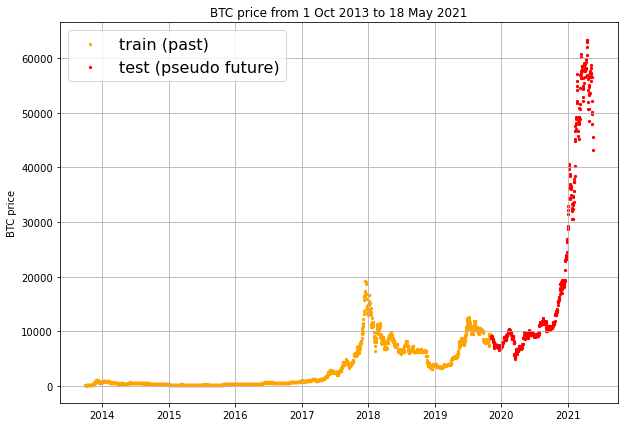

In [67]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, c='orange', label='train (past)')
plt.scatter(X_test, y_test, s=5, c='red', label='test (pseudo future)')
plt.legend(fontsize=16)
plt.grid(True)
plt.ylabel('BTC price')
plt.title('BTC price from 1 Oct 2013 to 18 May 2021');

## Model 0 | Naive forecast
in formular : $$\hat{y}_{t} = y_{t-1}$$

the prediction at timestep t(y-hat) is equal to the value at timestep t-1 (previous timestep) - for horizon of 1

**For example**, suppose we have the following sales of a given product during the first three months of the year:

<img src="https://www.statology.org/wp-content/uploads/2020/12/naive_forecast2-300x181.png"/>

The forecast for sales in April would simply be equal to the actual sales from the previous month of March:

*Although this method is simple, it tends to work surprisingly well in practice.*

In [86]:
#create Naive forecast
naive_forecast = y_test[:-1]
print('forecast :',naive_forecast[-4:])
print('actual :',y_test[-4:])

forecast : [49764.1320816  50032.69313676 47885.62525472 45604.61575361]
actual : [50032.69313676 47885.62525472 45604.61575361 43144.47129086]


### MASE (Mean Absolute Scaled Error) 
for time series forcasting metrics

metric that allows you to compare two models. Using the MAE for each model, If the MASE value is less than 1, then the new model performs better. If the MASE value is greater than 1, then the original model performed better than the new model.

<img src="https://miro.medium.com/max/964/1*hImatS5n4JjrAP09f0qduQ.png"/>

In [113]:
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    """
    mae = np.mean(np.abs(y_true - y_pred))
    mae_naive = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive # original model is naive forcast

In [111]:
mean_absolute_scaled_error(y_test[1:], naive_forecast)

0.9995699939182626

In [114]:
#create evaluate metrics
def evaluate_score(y_true, y_pred) :
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean(np.square(y_true - y_pred))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred )/y_true)) # Mean absolute percentage error
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        'mae':mae,
        'mse':mse,
        'rmse':rmse,
        'mape':mape,
        'mase':mase
    }

In [115]:
naive_score = evaluate_score(y_test[1:], naive_forecast)
naive_score

{'mae': 567.9802273457542,
 'mse': 1147547.125023896,
 'rmse': 1071.2362601330744,
 'mape': 0.02516524929982267,
 'mase': 0.9995699939182626}

### windowing our dataset
to turn data into a supervised learning problem

windowing for 1 week:<br>
[0, 1, 2, 3, 4, 5, 6] -> [7]<br>
[1, 2, 3, 4, 5, 6, 7] -> [8]

In [118]:
print(prices[:7] ,'->',prices[7])

[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> 123.033


In [418]:
HORIZON = 1 #number of prediction (next 1 day)
WINDOW_SIZE = 7 #number of feature

def windowing_labels(labels, horizon=1, window_size=7):
    '''
    create label of window dataset
    window_size = 7, horizon = 1:

    [0, 1, 2, 3, 4, 5, 6] -> [7]

    [1, 2, 3, 4, 5, 6, 7] -> [8]
    '''
    labels = np.array(labels)
    window_step = np.arange(window_size+horizon).reshape(1,-1) #range(8) = [0,1,2,3,...,7]
    window_index = window_step + np.arange(len(labels)-(window_size+horizon-1)).reshape(-1,1) # [0],
                                                                                              # [1],...
                                                                                              # [len(...)]
    f = labels[window_index]

    return pd.DataFrame({
    'window':list(f[:,:-horizon]),
    'label':list(f[:,-horizon:])
    })


In [439]:
window_df = windowing_labels(prices, horizon=1)
window_df.head()

,window,label
0,"[123.65499, 125.455, 108.58483, 118.67466, 121...",[123.033]
1,"[125.455, 108.58483, 118.67466, 121.33866, 120...",[124.049]
2,"[108.58483, 118.67466, 121.33866, 120.65533, 1...",[125.96116]
3,"[118.67466, 121.33866, 120.65533, 121.795, 123...",[125.27966]
4,"[121.33866, 120.65533, 121.795, 123.033, 124.0...",[125.9275]


In [440]:
windows = window_df['window'].to_numpy()
labels = window_df['label'].to_numpy()

In [441]:
#turning window to train and test sets
def make_train_test_split(windows, labels, test_size=.2):
    train_size = int(len(windows) * (1 - test_size))
    train_windows = windows[:train_size]
    train_labels = labels[:train_size]
    test_windows = windows[train_size:]
    test_labels = labels[train_size:]

    return train_windows, test_windows, train_labels, test_labels

In [442]:
#create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows, labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

### Create ModelCheckpoint

In [459]:
def crete_model_checkpoint(model_name, save_path='model_experiment'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), save_best_only=True)